In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import simpson
from ed import *
from dos import *
import warnings
warnings.filterwarnings("ignore")

In [8]:
def get_G0_semicirc(omFs, mu, t):
    from dos import semicircle
    from scipy.integrate import simpson
    ws = np.linspace(-2*t,2*t,1000)
    sc_dos = semicircle(ws,t)
    G0 = np.zeros(len(omFs),dtype=complex)
    for iomF, omF in enumerate(omFs):
        y = sc_dos/(1j*omF+mu-ws)
        G0[iomF] = simpson(y, ws)
    return G0

In [9]:
def get_G0_aim(omFs, V, eb, ed, mu):
    G0_aim = np.zeros(len(omFs),dtype=complex)
    for iomF, omF in enumerate(omFs):
        Delta = 0.0
        for ib in range(eb.shape[0]):
            Delta += (V[ib]*np.conj(V[ib])).real/(1j*omF-eb[ib])
        G0_aim[iomF] = 1./(1j*omF - ed + mu - Delta)
    return G0_aim

def get_G0w_aim(ws, eta, V, eb, ed, mu):
    G0_aim = np.zeros((len(ws)),dtype=complex)
    for iw, w in enumerate(ws):
        Delta = 0.0
        for ib in range(eb.shape[0]):
            Delta += (V[ib]*np.conj(V[ib])).real/(w + 1j*eta - eb[ib])
        G0_aim[iw] = (1./(w + 1j*eta - ed + mu - Delta))[0]
    return G0_aim

In [10]:
def cost_func(x, *args):
    omFs, ed, mu, G0, Nb, Nmax = args
    V = x[:Nb] + 1j*x[Nb:2*Nb]
    eb = x[2*Nb:3*Nb]
    G0_aim = get_G0_aim(omFs, V, eb, ed ,mu)
    cost = 0.0
    for iomF in range(Nmax):
        diff = 1./G0_aim[iomF] - 1./G0[iomF]
        cost += (np.conj(diff)*diff).real/omFs[iomF]**1
    return cost 

In [ ]:
np.random.seed(123)
np.set_printoptions(suppress=True, precision=8)
# initial density of state
T = 0.005
t = 0.5
mu = 0.0
Nb = 3
Nmax = 100
mix = 0.5
maxit = 500

NomF = Nmax
omFs = (2*np.arange(NomF)+1)*np.pi*T

G0 = get_G0_semicirc(omFs, mu, t)

no = 2*(1+Nb)
print('no=',no)
FH_list = build_fermion_op(no)
print(len(FH_list))
FH_list_dense = [np.array(FH.todense(),dtype=complex) for FH in FH_list]

ebs = np.random.uniform(-1,1,Nb)
Vrs = np.random.uniform(-0.5,0.5,Nb)
Vis = np.zeros((Nb))
x0 = np.hstack((Vrs,Vis,ebs))
  
U = 3.5

it = 0
diff = 1e20
while diff > 5e-5 and it<maxit:
    print("-------------------------------------- it=%d U=%.2f --------------------------------------"%(it, U))

    # fit V eb
    args = omFs, 0.0, mu, G0, Nb, Nmax
    result = minimize(cost_func,x0,args=args, method='L-BFGS-B', options={'gtol': 1e-2, 'eps': 1e-12})
    print("GA root convergence message---------------------------------")
    print("sucess=",result.success)
    print(result.message)
    V = result.x[:Nb] + 1j*result.x[Nb:2*Nb]
    eb = result.x[2*Nb:3*Nb]
    x0 = result.x
    print('V=',V)
    print('eb=', eb)
    
    # ED part
    h1 = np.array([[-U/2+mu, 0.0],
                   [ 0.0,-U/2+mu]])
    eb = np.kron(eb,np.ones((2)))
    V = np.kron(V,np.eye(2)).T
    
    V2E = np.zeros((2,2,2,2))
    V2E[1,1,0,0] = U
    V2E[0,0,1,1] = U
    print('V(ED)=',V)
    print('eb(ED)=', eb)

    dm, evals, evecs, docc = solve_Hemb_thermal(T, h1, V, eb, V2E, FH_list, verbose=0)
        
    print('dm=')
    print(dm.real)
    print('trace(dm)=',np.trace(dm).real)
    print('docc=', docc.real)
    
    GomF = compute_GomF_thermal(T, omFs, evals, evecs, FH_list_dense)
      
    # update G0
    G0_new = 1./(1j*omFs + mu - t**2*GomF)

    diff = np.sum(np.abs(G0_new  -G0))
    print('diff=', diff)
    it += 1
    G0 = (1-mix)*G0 + mix*G0_new

# real frequency quantities
ws = np.linspace(-5,5,200) # frequency mesh
eta = 0.1 #broadening factor
Gw = compute_Gw_thermal(T, ws, eta, evals, evecs, FH_list_dense) # real frequency impurity Green's function
G0w = get_G0w_aim(ws, eta, V[::2,::2], eb[::2], 0.0, mu) # real frequency non-interacting impurity Green's function
Sigw = 1./G0w - 1./Gw # real frequency self-energy
Glattw = compute_Glattw_semcircle(ws,eta,Sigw,mu) # real frequency lattice Green's function
# Matsubara self-energy
G0 = get_G0_aim(omFs, V[::2,::2], eb[::2], 0.0, mu) # matsubara frequency impurity Green's function
Sig = 1./G0 - 1./GomF # Matsubara frequency self-energy
Z = 1./(1-(Sig[0].imag)/(omFs[0])) # quasiparticle weight estimate from Matsubara self-energy
Glatt = compute_GlattomF_semcircle(omFs,Sig,mu) # real frequency lattice Green's function

np.savetxt('Gimpw_U%.2f.dat'%(U),np.vstack((ws,Gw.real,Gw.imag)).T)
np.savetxt('Glattw_U%.2f.dat'%(U),np.vstack((ws,Glattw.real,Glattw.imag)).T)
np.savetxt('Gimp_U%.2f.dat'%(U), np.vstack((omFs,GomF.real,GomF.imag)).T)
np.savetxt('Glatt_U%.2f.dat'%(U), np.vstack((omFs,Glatt.real,Glatt.imag)).T)
np.savetxt('G0_U%.2f.dat'%(U), np.vstack((omFs,G0.real,G0.imag)).T)
np.savetxt('Sig_U%.2f.dat'%(U), np.vstack((omFs,Sig.real,Sig.imag)).T)
np.savetxt('Sigw_U%.2f.dat'%(U), np.vstack((ws,Sigw.real,Sigw.imag)).T)
np.savetxt('x0_U%.2f.dat'%(U), x0)

print(U, dm[0,0].real, dm[1,1].real, docc.real, Z, diff)

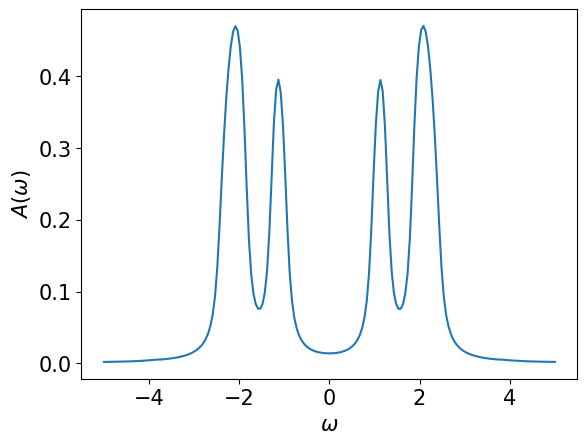

spectral weight= 0.9851307650358498


In [12]:
data = np.loadtxt('Glattw_U3.50.dat').T

plt.plot(data[0],-data[2]/np.pi)
plt.xlabel('$\omega$',size=15)
plt.ylabel('$A(\omega)$',size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()
print('spectral weight=', simpson(-data[2]/np.pi, data[0]))

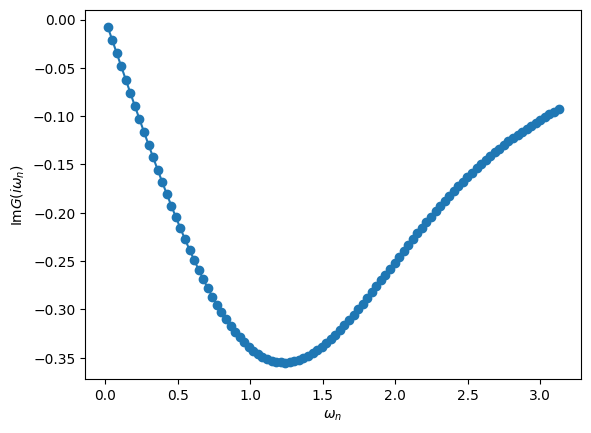

In [13]:
data = np.loadtxt('Glatt_U3.50.dat').T

plt.plot(data[0],data[2],'-o')
plt.xlabel('$\omega_n$')
plt.ylabel('Im$G(i\omega_n)$')
plt.show()

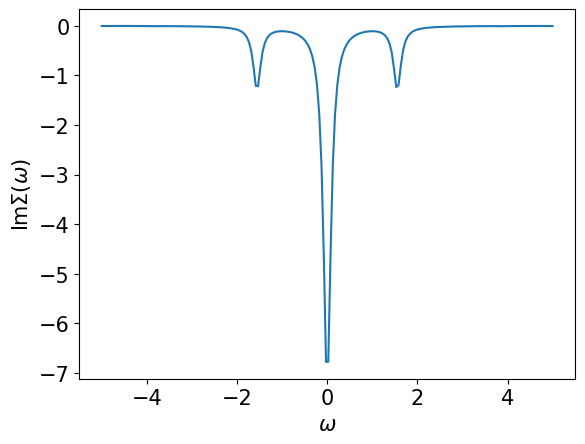

In [14]:
data = np.loadtxt('Sigw_U3.50.dat').T

plt.plot(data[0],data[2]/np.pi,'-')
plt.xlabel('$\omega$',size=15)
plt.ylabel('Im$\Sigma(\omega)$',size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

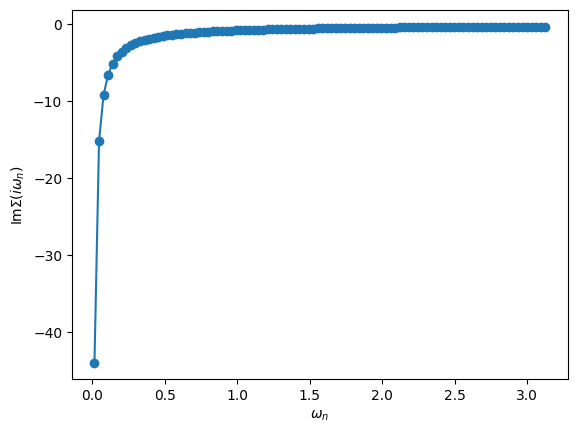

In [15]:
data = np.loadtxt('Sig_U3.50.dat').T

plt.plot(data[0],data[2]/np.pi,'-o')
plt.xlabel('$\omega_n$')
plt.ylabel('Im$\Sigma(i\omega_n)$')
plt.show()